# DenseNet121(Baseline)

In [ ]:
# Imports & Setup
import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os, sys

# dataset loader path
sys.path.append(os.path.abspath(".."))
from dataset import create_dataloaders

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Validation set accuracy evaluation function
def evaluate_accuracy(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Enhanced strategy list & result storage variables
strategies = ['minimal', 'default', 'extensive']
all_reports = []
all_class_names = None


Using device: cuda



=== Training with minimal ===
Epoch 1/10 | Loss: 97.8228 | Train Acc: 0.8665 | Val Acc: 0.8804 | Val Loss: 31.1222
Epoch 2/10 | Loss: 46.7608 | Train Acc: 0.9383 | Val Acc: 0.9083 | Val Loss: 24.0155
Epoch 3/10 | Loss: 36.2578 | Train Acc: 0.9508 | Val Acc: 0.9163 | Val Loss: 21.3542
Epoch 4/10 | Loss: 27.8951 | Train Acc: 0.9587 | Val Acc: 0.8979 | Val Loss: 25.0732
Epoch 5/10 | Loss: 26.9491 | Train Acc: 0.9617 | Val Acc: 0.9225 | Val Loss: 19.4922
Epoch 6/10 | Loss: 21.6870 | Train Acc: 0.9664 | Val Acc: 0.9171 | Val Loss: 20.2432
Epoch 7/10 | Loss: 19.7814 | Train Acc: 0.9726 | Val Acc: 0.9154 | Val Loss: 22.1406
Epoch 8/10 | Loss: 16.4073 | Train Acc: 0.9767 | Val Acc: 0.8812 | Val Loss: 31.7136
Epoch 9/10 | Loss: 17.3845 | Train Acc: 0.9746 | Val Acc: 0.9004 | Val Loss: 23.9454
Epoch 10/10 | Loss: 16.6567 | Train Acc: 0.9761 | Val Acc: 0.9213 | Val Loss: 22.2631


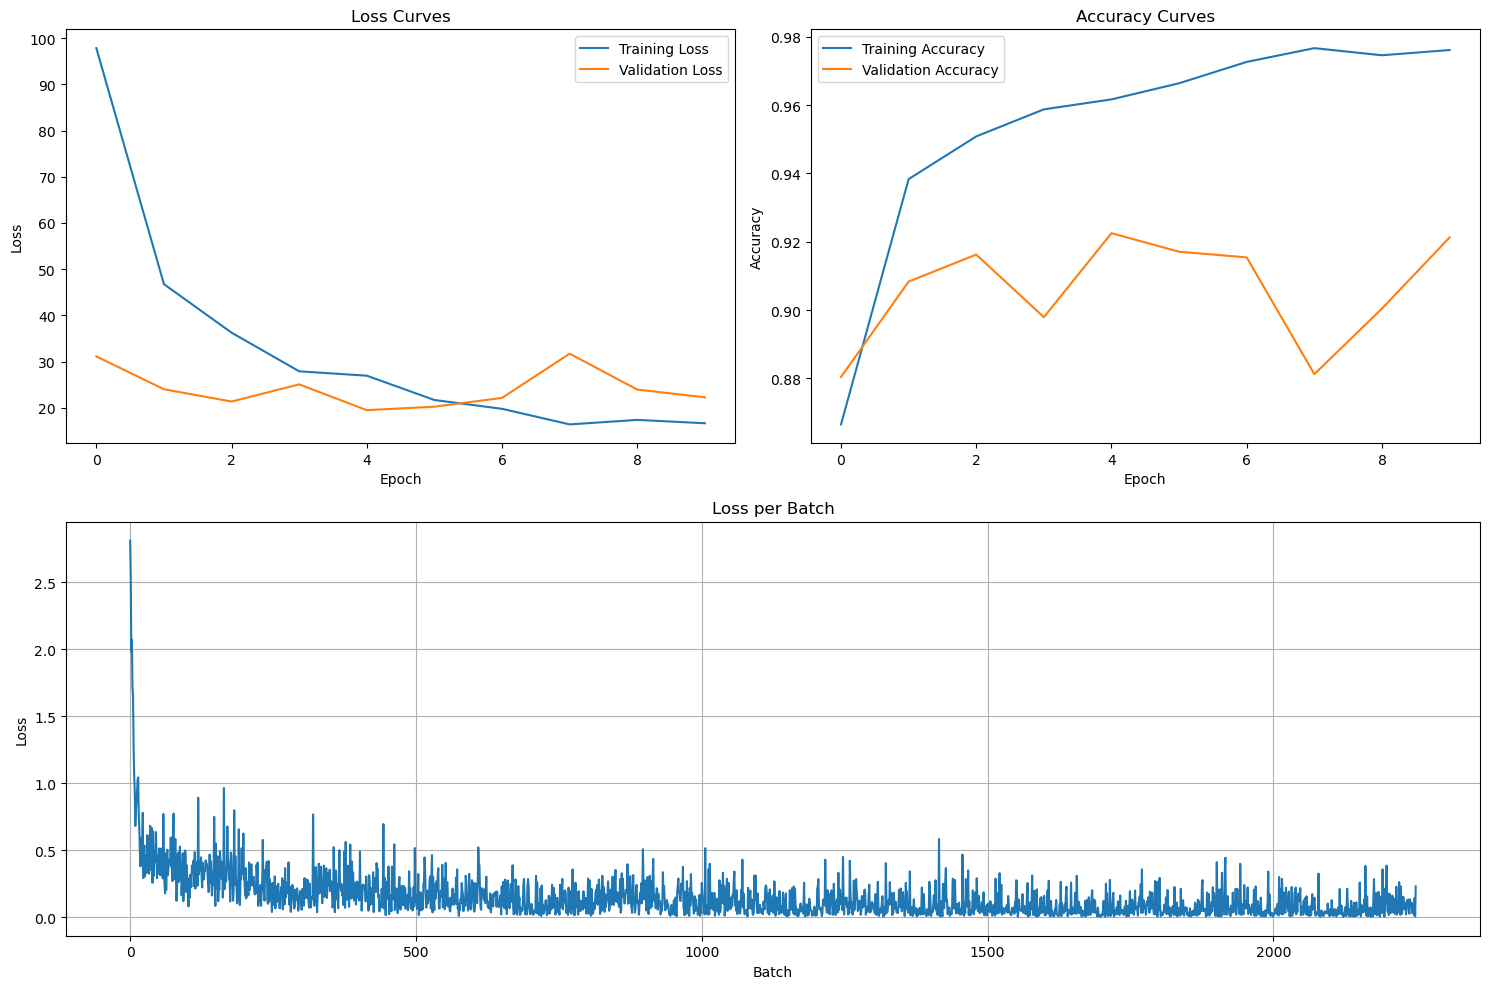


=== Training with default ===
Epoch 1/10 | Loss: 159.4737 | Train Acc: 0.7789 | Val Acc: 0.8271 | Val Loss: 42.4922
Epoch 2/10 | Loss: 96.6586 | Train Acc: 0.8628 | Val Acc: 0.8467 | Val Loss: 38.7269
Epoch 3/10 | Loss: 76.3916 | Train Acc: 0.8906 | Val Acc: 0.8213 | Val Loss: 47.0468
Epoch 4/10 | Loss: 70.0761 | Train Acc: 0.8965 | Val Acc: 0.8933 | Val Loss: 27.0219
Epoch 5/10 | Loss: 61.0804 | Train Acc: 0.9100 | Val Acc: 0.8954 | Val Loss: 26.2389
Epoch 6/10 | Loss: 58.0053 | Train Acc: 0.9181 | Val Acc: 0.8400 | Val Loss: 47.6478
Epoch 7/10 | Loss: 54.7218 | Train Acc: 0.9190 | Val Acc: 0.8662 | Val Loss: 36.9964
Epoch 8/10 | Loss: 48.9421 | Train Acc: 0.9290 | Val Acc: 0.8933 | Val Loss: 29.4355
Epoch 9/10 | Loss: 47.1827 | Train Acc: 0.9324 | Val Acc: 0.8988 | Val Loss: 26.9708
Epoch 10/10 | Loss: 43.2155 | Train Acc: 0.9360 | Val Acc: 0.9029 | Val Loss: 26.7930


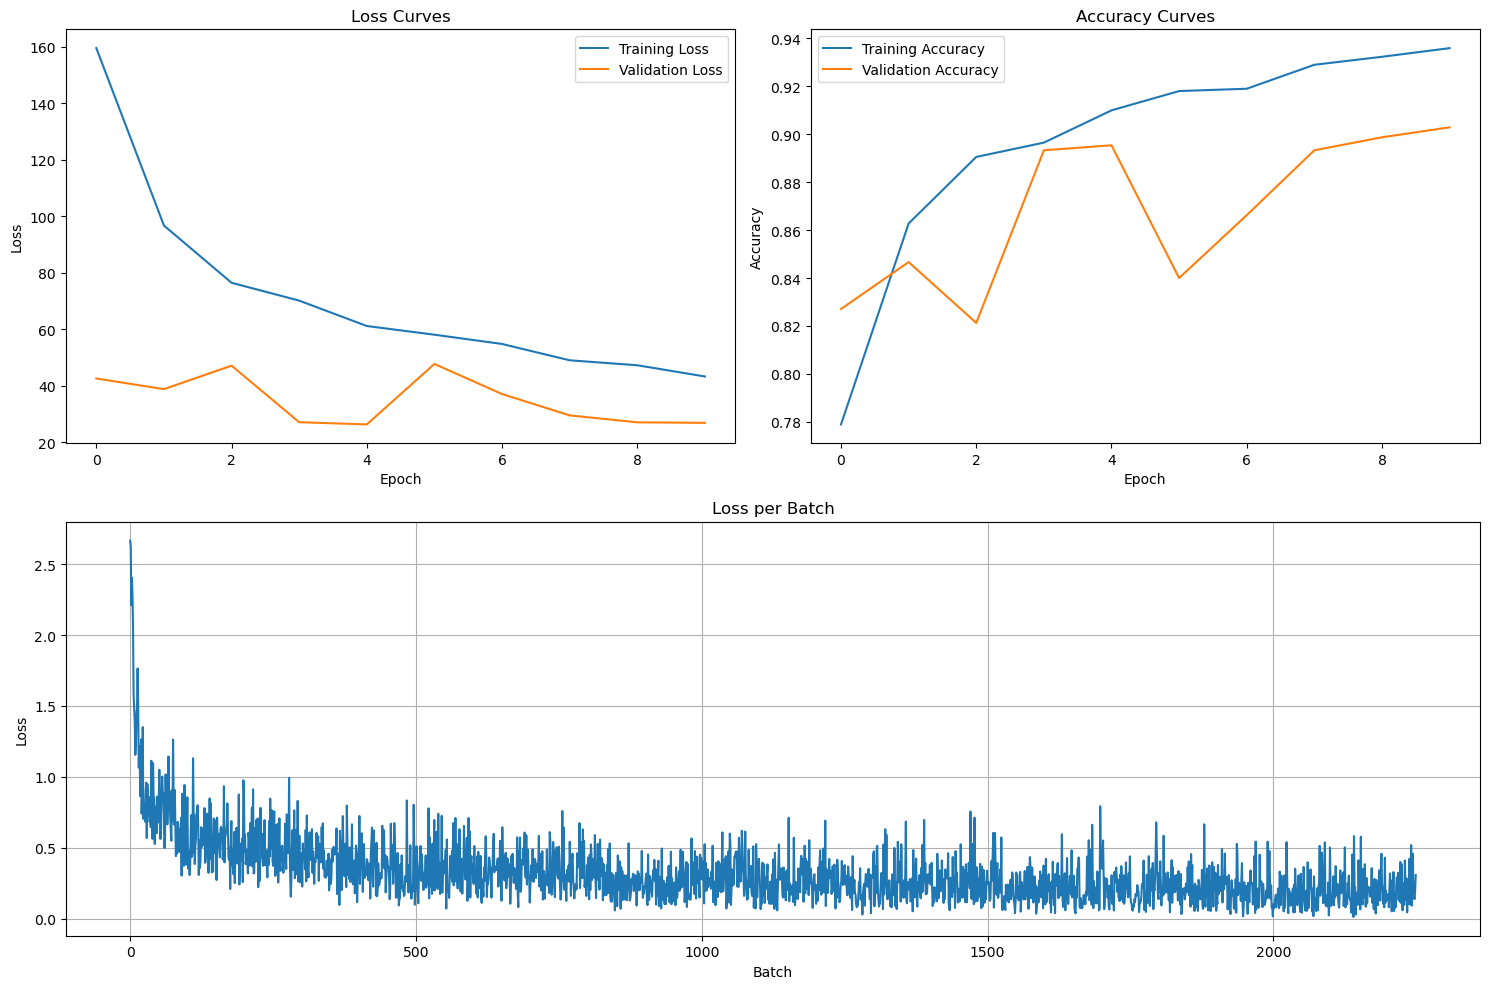


=== Training with extensive ===
Epoch 1/10 | Loss: 198.4135 | Train Acc: 0.7197 | Val Acc: 0.7875 | Val Loss: 51.1101
Epoch 2/10 | Loss: 126.0996 | Train Acc: 0.8175 | Val Acc: 0.8146 | Val Loss: 48.5859
Epoch 3/10 | Loss: 110.4721 | Train Acc: 0.8389 | Val Acc: 0.8562 | Val Loss: 42.1115
Epoch 4/10 | Loss: 97.7469 | Train Acc: 0.8543 | Val Acc: 0.8271 | Val Loss: 48.8008
Epoch 5/10 | Loss: 86.9916 | Train Acc: 0.8774 | Val Acc: 0.8596 | Val Loss: 36.7319
Epoch 6/10 | Loss: 86.5844 | Train Acc: 0.8774 | Val Acc: 0.8592 | Val Loss: 37.8912
Epoch 7/10 | Loss: 78.8942 | Train Acc: 0.8846 | Val Acc: 0.8717 | Val Loss: 35.2941
Epoch 8/10 | Loss: 74.4959 | Train Acc: 0.8914 | Val Acc: 0.8413 | Val Loss: 42.8963
Epoch 9/10 | Loss: 67.7636 | Train Acc: 0.9000 | Val Acc: 0.8738 | Val Loss: 32.4738
Epoch 10/10 | Loss: 72.4404 | Train Acc: 0.8938 | Val Acc: 0.8788 | Val Loss: 34.1641


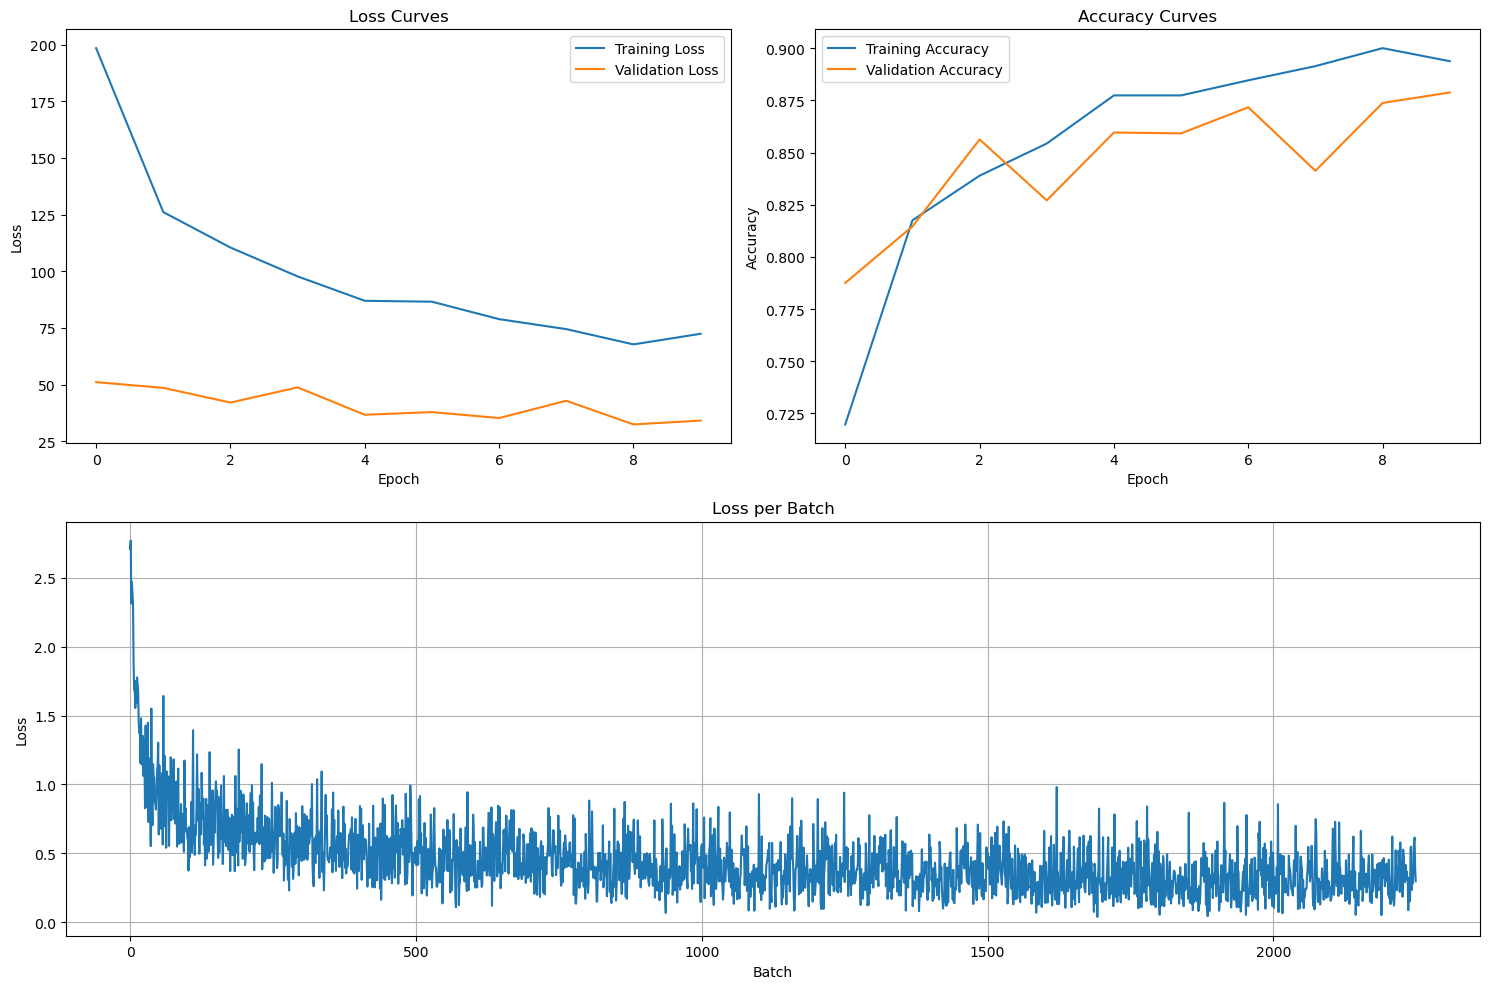


Global best model saved: saved_models/best_model_minimal.pth (Strategy: minimal, Val Acc: 0.9225)


In [ ]:
# Three enhancement strategies to train and save the global optimal model
global_best_acc = 0.0
global_best_state = None
global_best_strategy = None

for strategy in strategies:
    print(f"\n=== Training with {strategy} ===")
    train_loader, val_loader, _, class_names = create_dataloaders(
        root_dir=os.path.abspath(os.path.join("..","Aerial_Landscapes")),
        batch_size=32,
        augmentation_strategy=strategy,
        verbose=False
    )
    if all_class_names is None:
        all_class_names = class_names

    # Model initialization
    weights = DenseNet121_Weights.DEFAULT
    model = densenet121(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, len(class_names))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    best_val_acc = 0.0
    best_state = None
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[], 'batch_losses':[]}

    # Training loop
    for epoch in range(10):
        model.train()
        running_loss = 0.0
        corr = tot = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            history['batch_losses'].append(loss.item())
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            corr += (preds == labels).sum().item()
            tot += labels.size(0)

        train_acc = corr / tot
        history['train_loss'].append(running_loss)
        history['train_acc'].append(train_acc)

        # Validation set evaluation
        model.eval()
        val_loss = val_corr = val_tot = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                val_corr += (preds == labels).sum().item()
                val_tot += labels.size(0)

        val_acc = val_corr / val_tot
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/10 | Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    # Plotting training curves
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curves'); plt.legend()

    plt.subplot(2,2,2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curves'); plt.legend()

    plt.subplot(2,1,2)
    plt.plot(range(len(history['batch_losses'])), history['batch_losses'])
    plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Loss per Batch'); plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Update the global optimum
    if best_val_acc > global_best_acc:
        global_best_acc = best_val_acc
        global_best_state = best_state
        global_best_strategy = strategy

# Save the global best model
os.makedirs("saved_models", exist_ok=True)
save_path = f"saved_models/best_model_{global_best_strategy}.pth"
torch.save(global_best_state, save_path)
print(f"\nGlobal best model saved: {save_path} (Strategy: {global_best_strategy}, Val Acc: {global_best_acc:.4f})")


Loading model: saved_models/best_model_minimal.pth

=== Testing minimal with best model ===


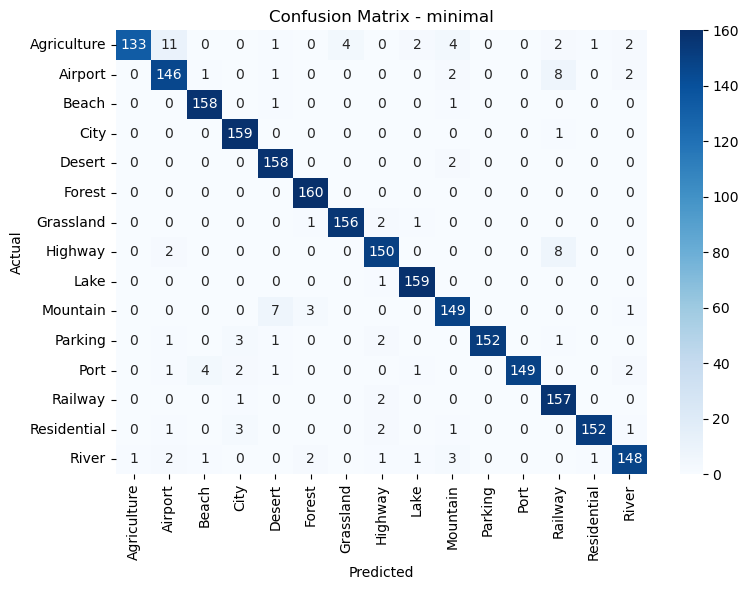


Classification Report (minimal):


,precision,recall,f1-score
Agriculture,0.993,0.831,0.905
Airport,0.890,0.912,0.901
Beach,0.963,0.988,0.975
City,0.946,0.994,0.970
Desert,0.929,0.988,0.958
Forest,0.964,1.000,0.982
Grassland,0.975,0.975,0.975
Highway,0.938,0.938,0.938
Lake,0.970,0.994,0.981
Mountain,0.920,0.931,0.925



=== Testing default with best model ===


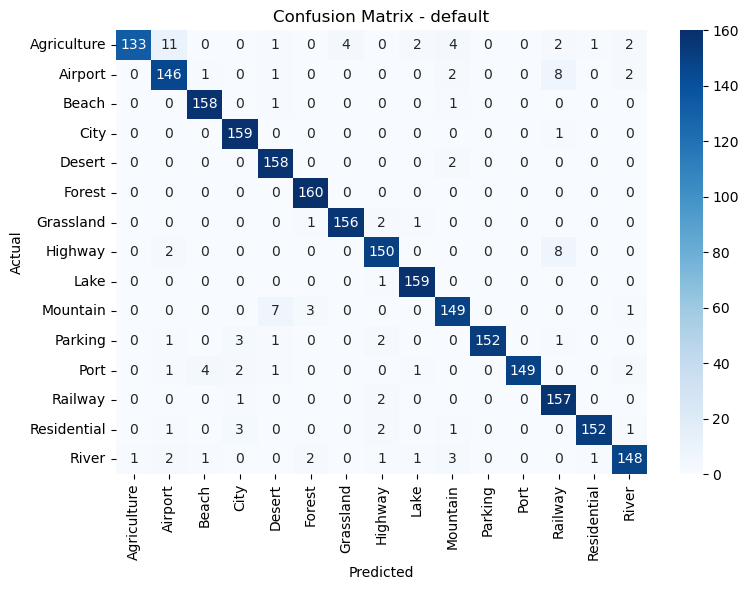


Classification Report (default):


,precision,recall,f1-score
Agriculture,0.993,0.831,0.905
Airport,0.890,0.912,0.901
Beach,0.963,0.988,0.975
City,0.946,0.994,0.970
Desert,0.929,0.988,0.958
Forest,0.964,1.000,0.982
Grassland,0.975,0.975,0.975
Highway,0.938,0.938,0.938
Lake,0.970,0.994,0.981
Mountain,0.920,0.931,0.925



=== Testing extensive with best model ===


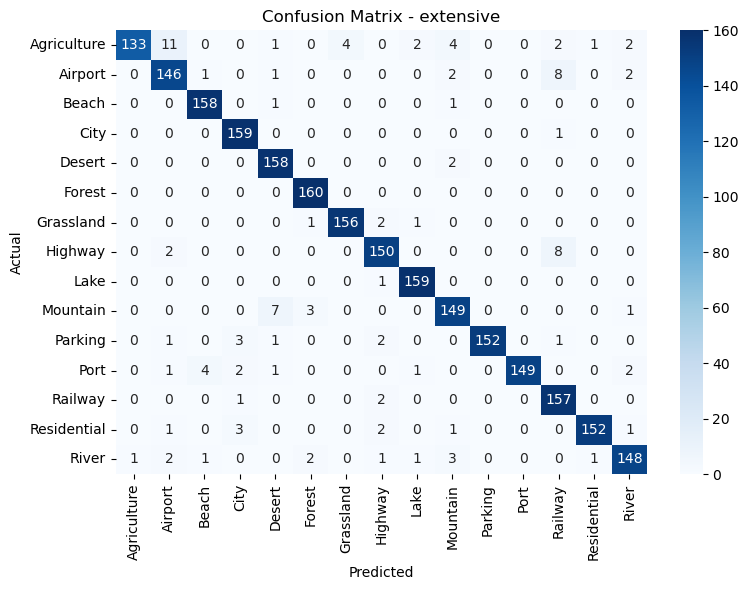


Classification Report (extensive):


,precision,recall,f1-score
Agriculture,0.993,0.831,0.905
Airport,0.890,0.912,0.901
Beach,0.963,0.988,0.975
City,0.946,0.994,0.970
Desert,0.929,0.988,0.958
Forest,0.964,1.000,0.982
Grassland,0.975,0.975,0.975
Highway,0.938,0.938,0.938
Lake,0.970,0.994,0.981
Mountain,0.920,0.931,0.925



=== Final Comparison Table ===


In [ ]:
# Loading the best model & testing three strategies + visualization
save_path = f"saved_models/best_model_{global_best_strategy}.pth"
print("Loading model:", save_path)

results = []
for strategy in strategies:
    print(f"\n=== Testing {strategy} with best model ===")
    _, _, test_loader, class_names = create_dataloaders(
        root_dir=os.path.abspath(os.path.join("..","Aerial_Landscapes")),
        batch_size=32,
        augmentation_strategy=strategy,
        verbose=False
    )
    # Rebuilding the model structure
    model = densenet121(weights=DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Linear(model.classifier.in_features, len(class_names))
    model = model.to(device)

    # Loading weights
    state = torch.load(save_path, map_location=device, weights_only=True)
    model.load_state_dict(state)
    model.eval()

    y_true = []; y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {strategy}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Classification Reporting Form
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose().loc[class_names, ['precision','recall','f1-score']]
    print(f"\nClassification Report ({strategy}):")
    display(df.style.set_properties(**{'text-align':'center'}).format(precision=3))

    results.append((strategy, df))

# Final comparison table
final = pd.concat({s:df for s,df in results}, axis=1)
print("\n=== Final Comparison Table ===")
display(final.style.set_table_styles([
    {"selector":"th","props":[("text-align","center")]},
    {"selector":"td","props":[("text-align","center")]}
]).format(precision=3))
